# Stree view house number

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.plots import *
import pandas as pd
from fastai.conv_learner import *
from fastai.dataset import *

In [3]:
ls /fast/data/SVHN

extra/            models/          test.tar.gz      train_length.csv
extra_boxes.csv   test/            tmp/             train.tar.gz
extra.csv         test_boxes.csv   train/
extra_length.csv  test.csv         train_boxes.csv
extra.tar.gz      test_length.csv  train.csv


In [4]:
dataset_name = 'train'

In [5]:
home_dir = '/fast/data/SVHN/'

In [6]:
train_df = pd.read_csv(os.path.join(home_dir, '%s.csv' % dataset_name))

In [7]:
max([len(l.split(' ')) for l in list(train_df.tags)])

6

In [8]:
train_df.sample(3)

,image_name,tags
12110,20898,5 4 1
4065,13657,2 10
21095,28985,1 2 7


In [9]:
### Plot and review data

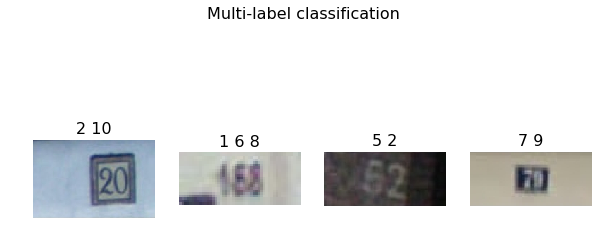

In [10]:
samples = train_df.sample(4)
list_paths = [f"{home_dir}{dataset_name}/{i}.png" for i in list(samples['image_name'])]
titles=list(samples['tags'])
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In [11]:
# model to pretrain is resnet 34, you can try with resnet18 or resnet52.
f_model = resnet34

In [12]:
!head -5 /fast/data/SVHN/train.csv

image_name,tags
1,1 9
10,1 6
100,1 10 9
1000,1 3


In [13]:
label_csv = os.path.join(home_dir, '%s.csv' %dataset_name)
bb_csv = os.path.join(home_dir, '%s_boxes.csv' %dataset_name)
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)
n, label_csv, bb_csv

(33402, '/fast/data/SVHN/train.csv', '/fast/data/SVHN/train_boxes.csv')

In [14]:
train_df = pd.read_csv(label_csv)
train_df['tags'] = train_df.tags.apply(lambda x: [float(i) for i in x.split(' ')])

In [15]:
train_df.head()

,image_name,tags
0,1,"[1.0, 9.0]"
1,10,"[1.0, 6.0]"
2,100,"[1.0, 10.0, 9.0]"
3,1000,"[1.0, 3.0]"
4,10000,"[1.0, 5.0, 3.0]"


In [16]:
((val_label,trn_label),) = split_by_idx(val_idxs, train_df)

In [17]:
val_label.head()

,image_name,tags
6,10002,"[2.0, 1.0, 10.0]"
7,10003,"[5.0, 9.0]"
8,10004,"[8.0, 8.0]"
17,10012,"[2.0, 9.0]"
23,10018,"[1.0, 6.0, 5.0, 8.0]"


In [18]:
trn_label.head()

,image_name,tags
0,1,"[1.0, 9.0]"
1,10,"[1.0, 6.0]"
2,100,"[1.0, 10.0, 9.0]"
3,1000,"[1.0, 3.0]"
4,10000,"[1.0, 5.0, 3.0]"


In [19]:
bb_csv

'/fast/data/SVHN/train_boxes.csv'

In [20]:
# image and bouding boxes.
!head {bb_csv}

image_name,boxes
1,77 246 295 326 81 323 299 418
10,6 25 32 33 4 34 30 47
100,1 18 22 22 0 23 21 31 0 32 21 41
1000,1 17 18 20 1 21 18 26
10000,20 45 48 59 23 57 51 71 23 70 51 87
10001,5 27 24 32 4 33 23 38
10002,16 144 61 167 23 165 68 187 23 183 68 206
10003,4 23 22 33 4 34 22 40
10004,2 30 36 47 1 49 35 63


In [21]:
def get_data(sz, bs=30):
    ### create an data loader with data augumentation.
    ## args:
    ##      sz: size of output image.
    ###     bs: batch size.
    ###     bb_csv: is image will bounding box.
    ###     I load boxes because I have set tfm_y=TfmType.COORD that will adjust bounding box when
    ###     augument image. And we will used this later when we predict box. Now you can ignore it.
    
    # augumentation function will be apply to input images.
    aug_tfms = [RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD), 
                RandomStretch(max_stretch=0.5),
               ]
    tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
    return ImageClassifierData.from_csv(home_dir, dataset_name, bb_csv, tfms=tfms, bs=bs, 
                                        suffix='.png', val_idxs=val_idxs, test_name='test',
                                        continuous=True, num_workers=4)

### Help function

In [22]:
from matplotlib import patches, patheffects
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_im_with_box(im, boxes):
    ax = show_img(im, figsize=(8,4))
    for b in boxes:
        b = bb_hw(b)
        draw_rect(ax, b)
        
def draw_im(im, boxes, cats):
    ax = show_img(im, figsize=(8,4))
    for b, c in zip(boxes, cats):
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], c, sz=16)

In [23]:
# create data loader with batch_size = 30, and output images will be 224:
data = get_data(224)
x, y = data.trn_ds[4]
x.shape, y.shape

((3, 224, 224), (12,))

In [24]:
# Output of datset is (image, boxes).
# We want to predict how many digits house number have.
# 1 digit  -> label 0, 
# 2 digits -> label 1, 
# 3 digits -> label 2, ...
class ConcatLblDataset(Dataset):
    def __init__(self, ds, labels):
        self.ds,self.labels = ds,labels
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        n_digit = len(self.labels[i])-1
        return x, n_digit

In [25]:
len(trn_label), len(val_label)

(26722, 6680)

In [26]:
trn_ds2 = ConcatLblDataset(data.trn_ds, list(trn_label.tags))
val_ds2 = ConcatLblDataset(data.val_ds, list(val_label.tags))
data.trn_dl.dataset = trn_ds2
data.val_dl.dataset = val_ds2

In [27]:
x, y = trn_ds2[15]
print(x.shape, y)

(3, 224, 224) 2


This house number have 3 digit.


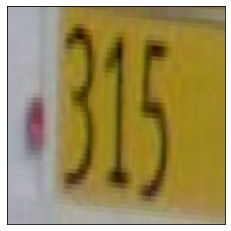

In [28]:
img = data.val_ds.ds.denorm(to_np(x))[0]
show_img(img)
print('This house number have %s digit.' % (y + 1))

In [29]:
# We defind header for our model. This head will be concat to the last layer of resnet.
class CountHead(nn.Module):
    def __init__(self, n):
        super().__init__()
        # Adaptive convert dynamic length of input to fixed length of output.
        self.adaptive = AdaptiveConcatPool2d((1,1))
        self.flatten = Flatten()
        # Dropout -> Fully connected -> Batch Norm -> ReLU
        self.layer1 = nn.Sequential(nn.Dropout(p=0.3), nn.Linear(n, 512), nn.BatchNorm1d(512), nn.ReLU())
        # Dropout -> Fully connected -> Batch Norm -> ReLU
        self.layer2 = nn.Sequential(nn.Dropout(p=0.3), nn.Linear(512, 512), nn.BatchNorm1d(512), nn.ReLU())
        # Fully connected. We don't need to use softmax here.
        # Softmax layer will be apply in loss function.
        self.layer3 = nn.Sequential(nn.Linear(512, 6))
        
    def forward(self, x):
        out = self.adaptive(x)
        out = self.flatten(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

In [30]:
count_head = CountHead(1024)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=count_head)
learn = ConvLearner(data, models, metrics=[accuracy])
learn.opt_fn = optim.Adam

In [31]:
count_head

CountHead(
  (adaptive): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=(1, 1))
    (mp): AdaptiveMaxPool2d(output_size=(1, 1))
  )
  (flatten): Flatten()
  (layer1): Sequential(
    (0): Dropout(p=0.3)
    (1): Linear(in_features=1024, out_features=512, bias=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (layer2): Sequential(
    (0): Dropout(p=0.3)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=512, out_features=6, bias=True)
  )
)

In [32]:
images, labels = next(iter(data.trn_dl))

In [33]:
images.shape, labels.shape

(torch.Size([30, 3, 224, 224]), torch.Size([30]))

In [34]:
pred = learn.model(images)

In [35]:
pred.shape

torch.Size([30, 6])

In [36]:
class MSECustomize(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.CrossEntropyLoss()
    def forward(self, pred, targ):    
        return self.loss(pred, targ[2])

In [37]:
learn.crit = nn.CrossEntropyLoss()

In [38]:
learn.crit(pred, labels)

tensor(1.8186, device='cuda:0', grad_fn=<NllLossBackward>)

In [39]:
# learn.summary()

In [40]:
# find the best learning rate
learn.lr_find(1e-5,10.)

 94%|█████████▍| 837/891 [01:53<00:08,  6.50it/s, loss=2.93] 

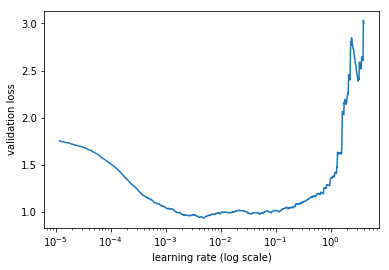

In [41]:
learn.sched.plot()

In [42]:
# the best learning rate:
# for more information https://www.youtube.com/watch?v=IPBSB1HLNLo
lr = 3e-4

## Training:
1. Using data with difference size will hepl model learn better.
2. Learn header params -> learn header params and 2 last layer of original model -> learn all params.

In [43]:
# Get data size 64 * 64
sz = 64
data = get_data(sz)
trn_ds2 = ConcatLblDataset(data.trn_ds, list(trn_label.tags))
val_ds2 = ConcatLblDataset(data.val_ds, list(val_label.tags))
data.trn_dl.dataset = trn_ds2
data.val_dl.dataset = val_ds2

In [44]:
# set data and learn header's params
learn.set_data(data)
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.875269   0.853624   0.651796  
    1      0.840773   0.799917   0.662575                    
    2      0.820519   0.783088   0.672605                    


[0.7830884192518132, 0.6726048256376547]

In [45]:
lrs = np.array([lr/100,lr/10,lr])

In [46]:
# learn header's params and 2 last layer of original model
learn.freeze_to(-2)
learn.fit(lrs, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.664698   0.660563   0.733383  
    1      0.588286   0.588822   0.764072                    
    2      0.535108   0.524066   0.792515                    


[0.5240662896749145, 0.7925150149061294]

In [47]:
# learn all params
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.523767   0.516032   0.797156  
    1      0.429257   0.497024   0.802994                    
    2      0.46761    0.472665   0.817515                    
    3      0.350277   0.467937   0.822006                    
    4      0.382524   0.468816   0.817515                    
    5      0.280859   0.474603   0.826048                    


[0.47460298485563185, 0.8260479512328873]

In [48]:
learn.save('svhn_001_resnet32')

In [49]:
learn.load('svhn_001_resnet32')

In [50]:
sz = 128
data = get_data(sz)
trn_ds2 = ConcatLblDataset(data.trn_ds, list(trn_label.tags))
val_ds2 = ConcatLblDataset(data.val_ds, list(val_label.tags))
data.trn_dl.dataset = trn_ds2
data.val_dl.dataset = val_ds2

In [51]:
learn.set_data(data)
learn.freeze()
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.78729    0.715727   0.704042  
    1      0.749166   0.68197    0.720958                    
    2      0.755145   0.667419   0.726946                    


[0.6674187123150883, 0.7269461461883819]

In [52]:
learn.freeze_to(-2)
learn.fit(lrs, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.433389   0.39437    0.845808  
    1      0.372066   0.35533    0.860928                    
    2      0.320061   0.338413   0.869611                    


[0.3384130602970184, 0.8696108300707297]

In [53]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.334048   0.344805   0.872006  
    1      0.249572   0.352552   0.870659                    
    2      0.250443   0.345458   0.872305                    
    3      0.184946   0.355435   0.878892                    
    4      0.19031    0.360898   0.87006                     
    5      0.131286   0.367414   0.875599                    


[0.3674137812068764, 0.8755988515244273]

In [54]:
learn.save('svhn_002_resnet32')

In [55]:
learn.load('svhn_002_resnet32')

In [56]:
sz = 256
data = get_data(sz)
trn_ds2 = ConcatLblDataset(data.trn_ds, list(trn_label.tags))
val_ds2 = ConcatLblDataset(data.val_ds, list(val_label.tags))
data.trn_dl.dataset = trn_ds2
data.val_dl.dataset = val_ds2

In [57]:
learn.set_data(data)
learn.freeze()
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.672302   0.559912   0.781587  
    1      0.625049   0.527185   0.795359                    
    2      0.606338   0.514774   0.800449                    


[0.51477402504422, 0.8004491502296425]

In [58]:
learn.freeze_to(-2)
learn.fit(lrs, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.387787   0.319269   0.881737  
    1      0.296445   0.285958   0.892515                    
    2      0.251849   0.271037   0.895509                    


[0.27103706075068185, 0.895509030736849]

In [59]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save('svhn_003_resnet32')

epoch      trn_loss   val_loss   accuracy                    
    0      0.235483   0.285338   0.890868  
    1      0.254367   0.282219   0.893862                    
    2      0.159934   0.281437   0.897006                    
    3      0.199929   0.290268   0.893413                    
    4      0.142093   0.282829   0.903593                    
    5      0.100857   0.298597   0.905838                     
    6      0.083205   0.308902   0.906587                     


In [60]:
learn.load('svhn_003_resnet32')

In [61]:
ls /fast/data/SVHN/models

svhn_001.h5                     svhn_number_002_pool3.h5
svhn_001_resnet32.h5            svhn_number_003.h5
svhn_002.h5                     svhn_number_003_num_boost.h5
svhn_002_resnet32.h5            svhn_number_003_pool2_extra.h5
svhn_003.h5                     svhn_number_003_pool2.h5
svhn_003_resnet32.h5            svhn_number_003_pool3.h5
svhn_box_001.h5                 svhn_number_004.h5
svhn_box_002.h5                 svhn_number_004_num_boost.h5
svhn_box_003.h5                 svhn_number_004_pool2_extra.h5
svhn_box_004.h5                 svhn_number_004_pool2.h5
svhn_number_001.h5              svhn_number_004_pool3.h5
svhn_number_001_pool2.h5        svhn_number_005.h5
svhn_number_001_pool3.h5        svhn_number_005_num_boost.h5
svhn_number_002.h5              svhn_number_005_pool2.h5
svhn_number_002_pool2_extra.h5  svhn_number_005_pool3.h5
svhn_number_002_pool2.h5        tmp.h5
